In [1]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt 
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F 
import collections,re,string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## DATA PROECESSING

In [2]:
train = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv") #(1306122,3)

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
STOPWORDS = stopwords.words("english")


def remove_mentions_and_tags(text):
    text = re.sub(r'@\S*', '', text)
    return re.sub(r'#\S*', '', text) 

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)


def remove_numbers(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def remove_punctuation(text):
    return ''.join([c for c in text if c not in string.punctuation])

                  
def clean_text(data):
    data = data.lower()
    data = remove_mentions_and_tags(data)
    data = remove_special_characters(data)
    data  = remove_numbers(data)
    data = remove_punctuation(data)
    data = " ".join([i for i in data.split() if i not in STOPWORDS])
    return data 
    

In [5]:
train_data = train["question_text"][:50000].apply(lambda x : clean_text(x))
train_targets = train["target"][:50000]

In [6]:
data_c = collections.Counter([word for sent in train_data for word in sent.split()]) #37097

In [7]:
train_data[:2].values

array(['quebec nationalists see province nation',
       'adopted dog would encourage people adopt shop'], dtype=object)

In [8]:
train["question_text"][:2].values

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?'],
      dtype=object)

In [9]:
x_train,x_test,y_train,y_test = train_test_split(train_data,train_targets,test_size=0.2,random_state=42)

In [10]:
x_train.shape,x_test.shape

((40000,), (10000,))

In [11]:
tf = TfidfVectorizer(max_features=1000)
x_train = tf.fit_transform(x_train)
x_test = tf.transform(x_test)

In [12]:
x_train = x_train.toarray()
x_test = x_test.toarray()

In [13]:
train_inputs = F.normalize(torch.tensor(x_train).float(),dim=0)
test_inputs = F.normalize(torch.tensor(x_test).float(),dim=0)

In [14]:
train_inputs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [15]:
train_ds = TensorDataset(train_inputs,torch.tensor(y_train.values))
test_ds = TensorDataset(test_inputs,torch.tensor(y_test.values))

In [16]:
train_loader = DataLoader(train_ds,batch_size=128,shuffle=True)
test_loader = DataLoader(test_ds,batch_size=128,shuffle=True)

In [17]:
sent,labels = next(iter(train_loader))
sent.shape

torch.Size([128, 1000])

## BUILDING MODEL

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.network = nn.Linear(1000,1)
    def forward(self,x):
        return self.network(x)

In [19]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2,self).__init__()
        self.network  = nn.Sequential(
            nn.Linear(1000,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self,x):
        sigmoid = nn.Sigmoid()
        return sigmoid(self.network(x))
        



In [20]:
model = Model2()
model

Model2(
  (network): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [21]:
losses = []
lr= 0.01
optim = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-5)
loss = nn.BCELoss()
epochs =  10

print("Training Progress ...")
for i in tqdm(range(epochs)):
    batch_losses = []
    for step,(texts,labels) in enumerate(train_loader):
        preds = model(texts)
        loss_ = loss(preds[:,0],labels.float())
        batch_losses.append(loss_.item())
        loss_.backward()
        optim.step()
        optim.zero_grad()
        #if step % 100 == 0:
            #print("STEP : {} LOSS : {:.2f}".format(step,loss.item()))
    #print("--RUNNING EPOCH : {}".format(i))
    losses.append(np.mean(batch_losses))
    


        

Training Progress ...


  0%|          | 0/10 [00:00<?, ?it/s]

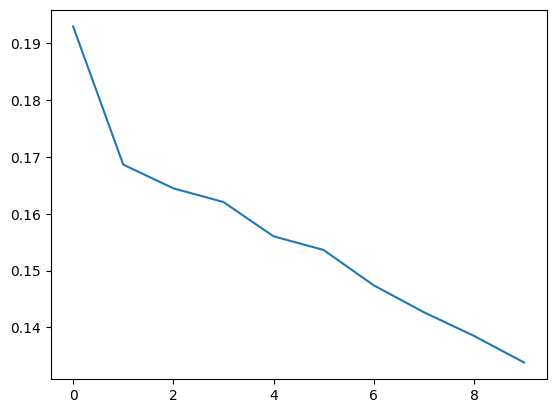

In [22]:
plt.plot(range(10),losses)

## EVALUATION

In [23]:
total = 0
correct  = 0

model.eval()
with torch.no_grad():
    for texts,labels in test_loader:
        preds = model(texts)
        probs = (loss(preds[:,0],labels.float()) > 0.5).int()
        total  +=  labels.size(0)
        correct  +=  (probs == labels).sum()
        

In [27]:
acc =  correct/total
print("Accuracy of the model  : {:.2f} %".format(acc*100))

Accuracy of the model  : 90.57 %
